In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import warnings

In [2]:
# Disable Warnings
warnings.filterwarnings('ignore')

In [3]:
# Load CSV file
reviews = pd.read_csv('data/YoutubeCommentsDataSet.csv', sep=',')

In [4]:
reviews.rename(columns={'Comment' : 'comment', 'Sentiment' : 'sentiment'}, inplace=True)

In [5]:
reviews['comment']

0        lets not forget that apple pay in 2014 require...
1        here in nz 50 of retailers don’t even have con...
2        i will forever acknowledge this channel with t...
3        whenever i go to a place that doesn’t take app...
4        apple pay is so convenient secure and easy to ...
                               ...                        
18403    i really like the point about engineering tool...
18404    i’ve just started exploring this field and thi...
18405    excelente video con una pregunta filosófica pr...
18406    hey daniel just discovered your channel a coup...
18407    this is great focus is key a playful approach ...
Name: comment, Length: 18408, dtype: object

In [6]:
reviews['sentiment']

0         neutral
1        negative
2        positive
3        negative
4        positive
           ...   
18403    positive
18404    positive
18405     neutral
18406    positive
18407    positive
Name: sentiment, Length: 18408, dtype: object

In [7]:
reviews = reviews[reviews['sentiment'] != 'neutral']

In [8]:
# Remove nulls from dataframe
reviews.dropna(inplace=True)

In [9]:
reviews['comment_length'] = reviews['comment'].str.len()

In [10]:
reviews['comment_length']

1        163
2        183
3        450
4        135
6         74
        ... 
18401    609
18403    277
18404    118
18406     88
18407    404
Name: comment_length, Length: 13739, dtype: int64

(0.0, 1000.0)

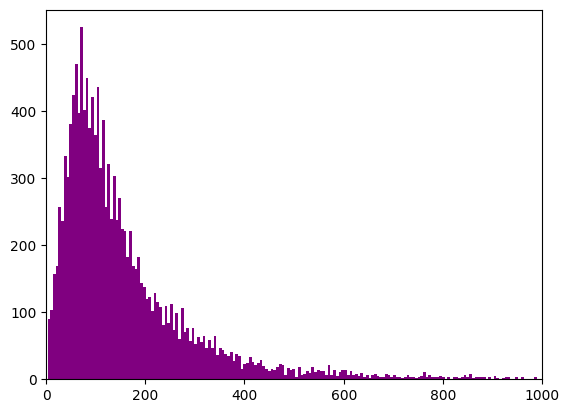

In [11]:
plt.hist(reviews['comment_length'], bins=1000, color='purple')
plt.xlim(0, 1000)

In [12]:
max(reviews['comment_length'])

5487

In [13]:
np.mean(reviews['comment_length'])

np.float64(171.05822840090255)

In [14]:
np.median(reviews['comment_length'])

np.float64(117.0)

In [15]:
# Remove duplicate rows
reviews = reviews[~reviews.duplicated()]
reviews

,comment,sentiment,comment_length
1,here in nz 50 of retailers don’t even have con...,negative,163
2,i will forever acknowledge this channel with t...,positive,183
3,whenever i go to a place that doesn’t take app...,negative,450
4,apple pay is so convenient secure and easy to ...,positive,135
6,we only got apple pay in south africa in 20202...,positive,74
...,...,...,...
18401,i come from a physics background and usually w...,positive,609
18403,i really like the point about engineering tool...,positive,277
18404,i’ve just started exploring this field and thi...,positive,118
18406,hey daniel just discovered your channel a coup...,positive,88


In [16]:
# Confirm duplicate rows have been removed
len(reviews[reviews.duplicated()])

0

In [17]:
# Set all reviews to lowercase to maintain consistency
reviews['comment'] = reviews['comment'].str.lower()

In [18]:
# Remove non-ASCII characters
reviews['comment'] = reviews['comment'].str.replace(r'[^\x00-\x7F]+', '', regex=True)

In [19]:
# Remove punctuation and numbers
reviews['comment'] = reviews['comment'].apply(lambda x : re.sub(r'[^A-Za-z\s]', '', x))

In [20]:
# Verify that unnecessary values were removed
mask = reviews['comment'].str.contains(r'[^A-Za-z ]', regex=True, na=False)
print(reviews[mask])

Empty DataFrame
Columns: [comment, sentiment, comment_length]
Index: []


In [21]:
# Remove extra spaces
reviews['comment'] = reviews['comment'].str.split().str.join(' ')

In [22]:
# Remove leading and trailing whitespace
reviews['comment'] = reviews['comment'].str.strip()

In [23]:
# Confirm there are no extra spaces (i.e., no more than 2 spaces together
mask = reviews['comment'].str.contains(r'\s{2,}', regex=True, na=False)
print(reviews[mask])

Empty DataFrame
Columns: [comment, sentiment, comment_length]
Index: []


In [24]:
# Get rid of stopwords and perform stemming
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = text.split()
    processed = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(processed)


reviews['comment'] = reviews['comment'].apply(preprocess)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Benji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Benji\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
reviews['comment'].head(10)

1     nz retailer dont even contactless credit card ...
2     forever acknowledge channel help lesson idea e...
3     whenever go place doesnt take apple pay doesnt...
4     apple pay convenient secure easy use used kore...
6            got apple pay south africa widely accepted
8     united state abundance retailer accept apple p...
10    wow really went town psu test rack thats serio...
11    lab exciting thing ive seen reallly going shak...
12    linus im engineer love lmg content across chan...
13    used time linus smartest guy room video clearl...
Name: comment, dtype: object

In [26]:
# Tokenize comments
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
X = reviews['comment']
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

Median: 12
90th percentile: 33.0


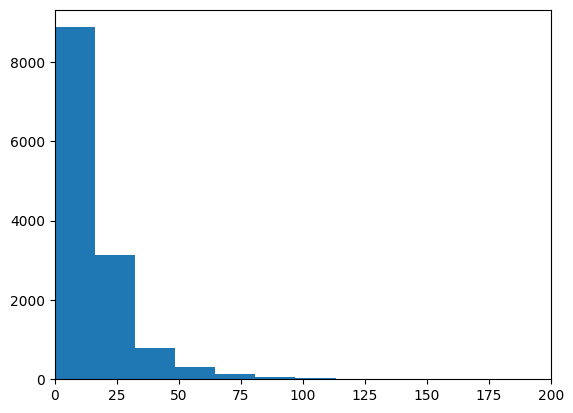

In [27]:
# Compute lengths of each sublist
lengths = [len(sublist) for sublist in X]

import statistics

plt.hist(lengths, bins=30)
plt.xlim(0, 200)

median_length = statistics.median(lengths)
print(f'Median: {median_length}')
print(f'90th percentile: {np.percentile(lengths, 90)}')

In [28]:
reviews['comment_lengths'] = reviews['comment'].str.split().apply(len)

(0.0, 200.0)

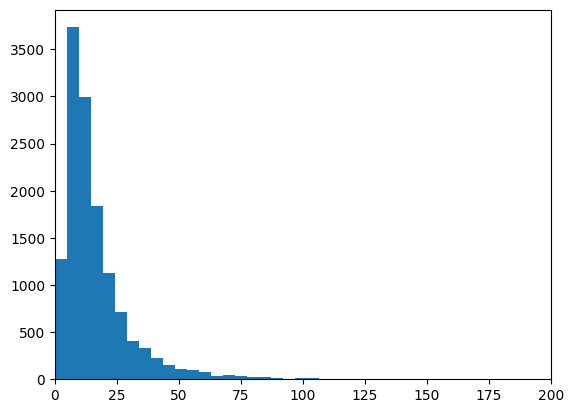

In [29]:
plt.hist(reviews['comment_lengths'], bins = 100)
plt.xlim(0, 200)

In [30]:
np.median(reviews['comment_lengths'])

np.float64(12.0)

In [31]:
maxlen = int(np.percentile(lengths, 90))
X = pad_sequences(X, maxlen=maxlen, padding='post', truncating='post')
y = reviews['sentiment']

In [32]:
from sklearn.preprocessing import LabelEncoder

# Convert sentiment column to 0's and 1's
le = LabelEncoder()
y = le.fit_transform(reviews['sentiment'])
y

array([0, 1, 0, ..., 1, 1, 1], shape=(13371,))

In [33]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)
y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], shape=(13371, 2))

In [34]:
X

array([[7484, 7485,   22, ...,    0,    0,    0],
       [ 719, 3960,   69, ...,    0,    0,    0],
       [ 467,   45,  275, ..., 2243,  347,  840],
       ...,
       [  29,  139, 3998, ...,    0,    0,    0],
       [ 282, 2733, 1130, ...,    0,    0,    0],
       [   9,  548,  809, ...,  992,  377,  541]],
      shape=(13371, 33), dtype=int32)

In [35]:
# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [36]:
# Evaluate Model
def evaluate_model(model, data_loader, criterion, device):
    model.eval() 
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted_classes = torch.max(outputs, 1)
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.squeeze().cpu().numpy())
            
    avg_loss = total_loss / len(data_loader.dataset)
    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_predictions)
    val_accuracy = accuracy_score(true_labels, predicted_labels)
    model.train() 
    return avg_loss, val_accuracy

In [37]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

VOCAB_SIZE = 10000
EMBED_SIZE = 256
LSTM_UNITS = 256
BATCH_SIZE = 128
N_EPOCHS = 15 

# Sentiment Model
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_units):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=embed_size,
            hidden_size=lstm_units,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Fully connected layers
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(lstm_units * 2, 64)
        self.relu = nn.ReLU()
        self.out = nn.Linear(64, 3)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Concatenate last hidden states from both directions
        h_forward = h_n[-2,:,:]
        h_backward = h_n[-1,:,:]
        h = torch.cat((h_forward, h_backward), dim=1)
        
        x = self.dropout(h)
        x = self.fc(x)
        x = self.relu(x)
        x = self.out(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SentimentModel(VOCAB_SIZE, EMBED_SIZE, LSTM_UNITS)
class_weights = torch.tensor([1.0, 1.5, 1.0], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

print("Model Architecture:\n", model)

Using device: cpu
Model Architecture:
 SentimentModel(
  (embedding): Embedding(10000, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=64, bias=True)
  (relu): ReLU()
  (out): Linear(in_features=64, out_features=3, bias=True)
)


In [38]:
from torch.utils.data import Dataset

# Sentiment Dataset
class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {
            'sequence': self.sequences[idx],
            'label': self.labels[idx]
        }
        return sample

In [39]:
from torch.utils.data import DataLoader

# Pass our training and validation data through custom dataset
train_data = SentimentDataset(X_train, y_train)
val_data = SentimentDataset(X_test, y_test)

# Dataloaders for batching
train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0 
)
val_loader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0 
)

In [40]:
from sklearn.metrics import accuracy_score
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train model
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    model.to(device)

    best_val_loss = float('inf')
    patience = 2
    trigger_times = 0

    # Loop through epochs
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        # Loop through each batch in train_loader
        for i, batch in enumerate(train_loader):
            inputs = batch['sequence'].to(device)
            labels = batch['label'].to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        # Evaluate train loss, val loss, and val accuracy
        train_loss = running_loss / len(train_loader.dataset)
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Print out model results
        print(f'Epoch {epoch+1}/{n_epochs}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}') 
        scheduler.step(val_loss)
        
train_model(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, device)

Epoch 1/15
Train Loss: 0.3792
Validation Loss: 0.2888
Validation Accuracy: 0.8407
Epoch 2/15
Train Loss: 0.2517
Validation Loss: 0.2554
Validation Accuracy: 0.8639
Epoch 3/15
Train Loss: 0.1688
Validation Loss: 0.2554
Validation Accuracy: 0.8755
Early stopping at epoch 4
